<a href="https://colab.research.google.com/github/muhammedkoussa/BrainTumorDetection/blob/main/Proje_Son_Hali_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uyarı mesajlarını görmezden gelmek için

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
'''
import shutil

shutil.rmtree('dosya yolu', ignore_errors=True)
'''
#klasörleri silmek için kod

"\nimport shutil\n\nshutil.rmtree('dosya yolu', ignore_errors=True)\n"

# Kaggle Python kütüphanesini yükledik.





In [ ]:
!pip install kaggle



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


*Kaggle API kullanabilmek için google drive tanımladık.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

Kaggle'den indirip drive yükledğimiz JSON doyasını kopyaladık.


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download ahmedhamada0/brain-tumor-detection

 89% 75.0M/84.0M [00:00<00:00, 116MB/s]
100% 84.0M/84.0M [00:00<00:00, 102MB/s]


In [ ]:
!unzip brain-tumor-detection

Gerekli olan kütüphanelerin import edilmesi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

* NumPy çok boyutlu dizileri, matrisleri ve üst düzey matematiksel işlevler ekleyen bir kitaplıktır
* MatPlotLib  görselleştirme kütüphanesidir.
* Os modülü Python'da hazır olarak gelen , dosya ve dizinlerde kolaylıkla işlemler yapmamızı sağlayan bir modüldür.
* math modülü matematiksel işlemler yapmanızı kolaylaştırmak için yazılmış bir modüldür.
* Shutil dizinler üzerinde bulunan dosyaları kopyalama , taşıma , açma, okuma , yazma ve kapatma gibi işlemleri “OS” modülü ile beraber basitçe yapmamızı sağlayan bir Python modülüdür.
* Glob modülü, Python'da belirli bir klasör içindeki dosyaları listelememize yardımcı olan harika bir modüldür. Bu modülü kullanırken filtreleme yaparak, sadece istenilen dosyaların listelenmesini de sağlayabiliyoruz.

In [ ]:
import os

# Colab'da boş bir klasör oluşturun
os.mkdir("DataSet")


# Klasörü Colab'daki "dosyalar" dizinine taşıyın
os.rename("yes", "DataSet/yes")
os.rename("no", "DataSet/no")


DataSette kaç adet resim bulunduğunu tespit eden kod

In [ ]:
ROOT_DIR = "/content/DataSet"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))

number_of_images.items()

dict_items([('yes', 1500), ('no', 1500)])

#veriyi şöyle ayırdık
* Train için %70
* Validation %15
* Test %15

Bu kod, verilen ROOT_DIR dizininin altındaki tüm dizinlerden rastgele seçilmiş resimleri belirtilen split oranına göre ikiye ayırır ve ayırdığı resimleri iki ayrı klasöre kopyalar.

In [ ]:
def dataFolder(p, split):

#Train için klasör oluşturduk
  if not os.path.exists("./"+p):
    os.mkdir("./"+p)

    for dir in os.listdir(ROOT_DIR):
       os.makedirs("./"+p+"/"+dir)

       for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR,dir)) ,
                                size=(math.floor(split*number_of_images[dir])-5),
                                replace=False ):
         O = os.path.join(ROOT_DIR,dir,img) #path
         D = os.path.join("./"+p,dir)
         shutil.copy(O,D)
         os.remove(O)

  else:
    print(f"{p} Bu Dosya Mevcuttur")

In [ ]:
dataFolder("train" , 0.7)

In [ ]:
dataFolder("val" , 0.15)

In [ ]:
dataFolder("test" , 0.15)

***MODEL OLUŞTURMA ***

In [ ]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras


CNN MODEL

eğitilmemiş boş model oluşturduk

In [ ]:
from keras.backend import dropout
model = Sequential()
model.add(Conv2D(filters= 16, kernel_size= (3,3), activation= 'relu', input_shape = (224,224,3) ))

model.add(Conv2D(filters= 36 , kernel_size= (3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 64,kernel_size= (3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 128 , kernel_size= (3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate= 0.25))
model.add(Flatten())
model.add(Dense(units=64,activation= 'relu'))

model.add(Dropout(rate=0.25))
model.add(Dense(units=1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

modeli eğitmek için kullanacagımız algoritmayı seçtik

data generator kullanarak verilerimizi hazırlıyoruz

verinin dataseti hazırlanılyor

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

dosya yolundan verilerin veriseti olarak hazırlanması ve gereken boyutlama işleme yaplıyor.

In [ ]:
def preprocessingImages1(path):
  """"
input : Path
output Pre processed images
"""
  image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, preprocessing_function=preprocess_input, horizontal_flip= True)
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')

  return image

In [ ]:
path = "/content/train"
train_data = preprocessingImages1(path)

Found 2090 images belonging to 2 classes.


In [ ]:
train_data.class_indices

{'no': 0, 'yes': 1}

test verisini orjinalliğine koruyarak dataset oluşturuyor.

In [ ]:
def preprocessingImages2(path):
  """"
input : Path
output Pre processed images
"""
  image_data = ImageDataGenerator(preprocessing_function=preprocess_input )
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')

  return image

In [ ]:
path = "/content/test"
test_data = preprocessingImages2(path)

Found 440 images belonging to 2 classes.


In [ ]:
path = "/content/val"
val_data = preprocessingImages2(path)

Found 440 images belonging to 2 classes.


Model Eğitimi

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet
import keras

Hızlı ve Güç tüketimi düşük bu tarz verilerde en yüksek doğruluk oranı veren MobileNet

In [ ]:
base_model = MobileNet(input_shape=(224,224,3), include_top= False)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
   layer.trainable = False

In [ ]:
X = Flatten()(base_model.output)
X = Dense(units=1 ,activation='sigmoid')(X)
model = Model(base_model.input, X)

In [ ]:
model. summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [ ]:
model.compile(optimizer='rmsprop', loss= keras.losses.binary_crossentropy , metrics=['accuracy'])

In [ ]:
#Call Back
from keras.callbacks import ModelCheckpoint, EarlyStopping
# model Check point
mc=ModelCheckpoint(filepath="bestmodel.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
#Early Stopping 5 kere improve olmazsa model.fit duraklar
es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=5, verbose=1)
cb = [mc,es]


In [ ]:
hist=model.fit_generator(train_data,
                         steps_per_epoch=6,
                         epochs=30,
                         verbose=1,
                         validation_data= val_data,
                         validation_steps= 10,
                         callbacks= cb)

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 10.3249 - accuracy: 0.5677
Epoch 1: val_accuracy improved from -inf to 0.74687, saving model to bestmodel.h5
6/6 [==============================] - 30s 4s/step - loss: 10.3249 - accuracy: 0.5677 - val_loss: 1.5229 - val_accuracy: 0.7469
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 3.3739 - accuracy: 0.7240
Epoch 2: val_accuracy improved from 0.74687 to 0.91875, saving model to bestmodel.h5
6/6 [==============================] - 20s 4s/step - loss: 3.3739 - accuracy: 0.7240 - val_loss: 0.3852 - val_accuracy: 0.9187
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 0.8165 - accuracy: 0.8698
Epoch 3: val_accuracy did not improve from 0.91875
6/6 [==============================] - 20s 4s/step - loss: 0.8165 - accuracy: 0.8698 - val_loss: 1.7412 - val_accuracy: 0.7312
Epoch 4/30
6/6 [==============================] - ETA: 0s - loss: 2.0850 - accuracy: 0.7396
Epoch 4: val_accuracy improved 

In [ ]:
#en iyi modeli yükleme
model = load_model("/content/bestmodel.h5")

In [ ]:
acc=model.evaluate_generator(test_data)[1]
print(f"our model accuracy is {acc*100} % ")

our model accuracy is 97.27272987365723 % 


# Yeni Bölüm

In [ ]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

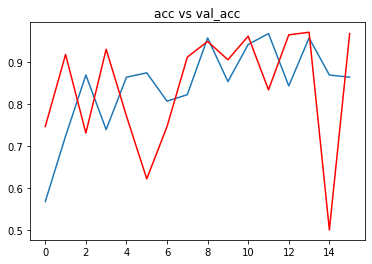

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c='red')
plt.title("acc vs val_acc")
plt.show()

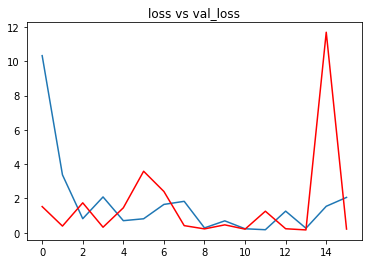

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c='red')
plt.title("loss vs val_loss")
plt.show()

In [ ]:
from keras.preprocessing import image

1/1 [==============================] - 0s 111ms/step
[[0.99636394]]
1/1 [==============================] - 0s 207ms/step
[[1.]]
Bu MR Görüntüsünde Tümör Tespit Edilmiştir.


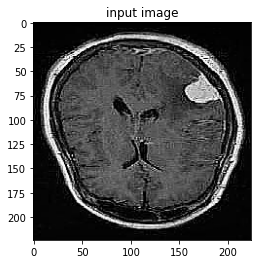

In [ ]:
# path for the image to see if it predics correct class
path = "/content/test/yes/y1001.jpg"

img = tf.keras.utils.load_img(path, target_size=(224,224) )

i = tf.keras.utils.img_to_array(img)/255
input_arr = np.array([i])

input_arr.shape
pred = np.round_(model.predict(input_arr))

print(model.predict(input_arr))
print(np.round_(model.predict(input_arr)))

if pred == 0:
  print("Bu MR Görüntüsünde Tümör Tespit Edilmemiştir.")

else :
  print("Bu MR Görüntüsünde Tümör Tespit Edilmiştir.")

# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()